## Spatio-Temporal Gaussian Process Regression (GPR)

In [34]:
import pandas as pd
import numpy as np

In [35]:
import skopt
print(skopt.__version__)

0.10.2


In [93]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

In [94]:
env_vars = ['PAR', 'SST', 'log_CHL', 'MLD', 'Salinity', 'DO', 'N_avg', 'P_avg', 'Fe_avg']
spatial_vars = ['coord1', 'coord2', 'coord3']  # derived from lat/lon
temporal_vars = ['time_sin', 'time_cos']       # derived from month


In [95]:
X_train = train_df[spatial_vars + temporal_vars + env_vars].values
y_train = train_df['log_y'].values
X_test = test_df[spatial_vars + temporal_vars + env_vars].values
y_test = test_df['log_y'].values


In [39]:
X_train[0]

array([ 0.60390378,  0.33685094,  0.72237917, -0.8660254 , -0.5       ,
       48.4980011 , 26.08687592, -0.84632104, 13.66929578, 34.331     ,
       85.128     ,  3.45595   ,  0.3684    ,  0.14471556])

In [40]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [41]:
# kernel for each part
space_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
time_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
env_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
noise = WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

# Kernel：Constant × (spatial + temporal + env) + noise
kernel = C(1.0) * (space_kernel + time_kernel + env_kernel) + noise

# GPR
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True, n_restarts_optimizer=5)

model = make_pipeline(StandardScaler(), gp)
model.fit(X_train, y_train)

/opt/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(alpha=0.0,
                                          kernel=1**2 * RBF(length_scale=1) + RBF(length_scale=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=5,
                                          normalize_y=True))])

In [42]:
print(model[-1].kernel_)

0.577**2 * RBF(length_scale=1.47) + RBF(length_scale=4.11) + RBF(length_scale=0.01) + WhiteKernel(noise_level=0.136)


Length_scale: 
The third RBF (envir) nucleus (0.902) responds to a rapidly changing pattern 
The first RBF (space) core (3.84) captures medium-scale changes 
The second RBF (time) core (9.12) captures the longest/smoothest trend 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


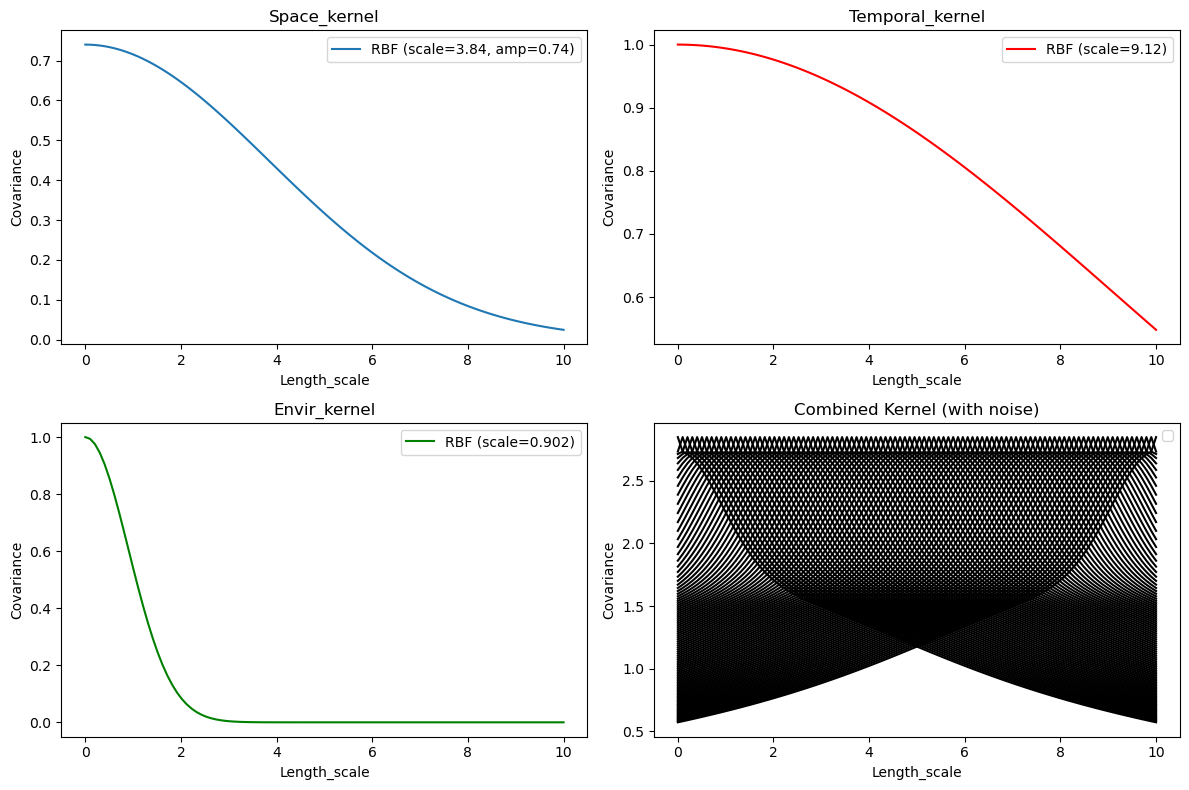

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# kernel function component
k1 = 0.74 * RBF(length_scale=3.84)
k2 = RBF(length_scale=9.12)
k3 = RBF(length_scale=0.902)
k_noise = WhiteKernel(noise_level=0.109)

# points
X = np.linspace(0, 10, 100)[:, np.newaxis]
# cov
K1 = k1(X, np.array([[0]]))  # reference: 0
K2 = k2(X, np.array([[0]]))
K3 = k3(X, np.array([[0]]))
K_total = k1(X) + k2(X) + k3(X) + k_noise(X)

# cov function
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(X, K1, label=f'RBF (scale=3.84, amp=0.74)')
plt.title('Space_kernel')
plt.xlabel('Length_scale')
plt.ylabel('Covariance')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(X, K2, 'r', label=f'RBF (scale=9.12)')
plt.title('Temporal_kernel')
plt.xlabel('Length_scale')
plt.ylabel('Covariance')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(X, K3, 'g', label=f'RBF (scale=0.902)')
plt.title('Envir_kernel')
plt.xlabel('Length_scale')
plt.ylabel('Covariance')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(X, K_total, 'k')
plt.title('Combined Kernel (with noise)')
plt.xlabel('Length_scale')
plt.ylabel('Covariance')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [45]:
y_pred, std_pred = model.predict(X_test, return_std=True)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

RMSE: 0.5778, R²: 0.3865


In [46]:
import matplotlib.pyplot as plt

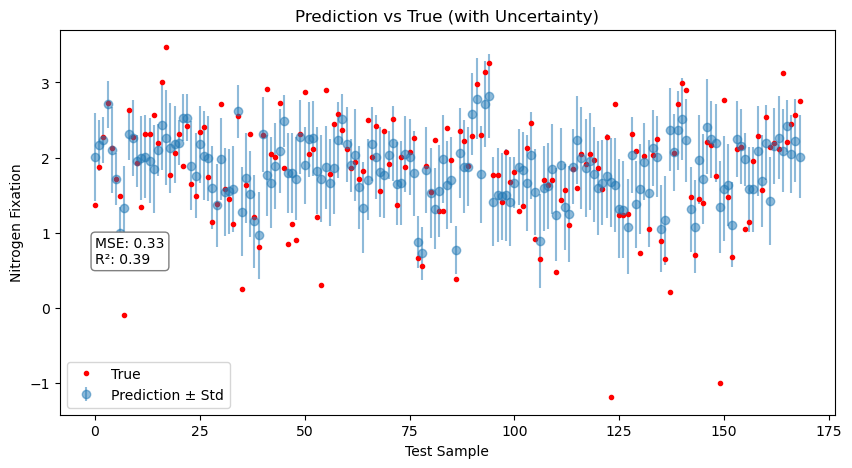

In [47]:
mse = rmse*rmse
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(y_pred)), y_pred, yerr=std_pred, fmt='o', alpha=0.5, label='Prediction ± Std')
plt.plot(y_test, 'r.', label='True')
plt.text(
        0.05, 0.95, f'MSE: {mse:.2f}\nR²: {r2:.2f}',
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
    )
plt.title("Prediction vs True (with Uncertainty)")
plt.xlabel("Test Sample")
plt.ylabel("Nitrogen Fixation")
plt.legend()
plt.show()


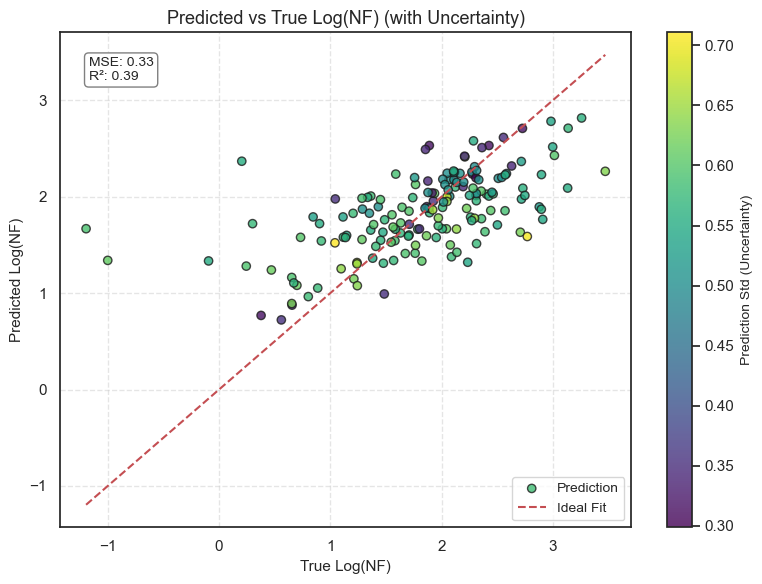

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 白色背景
sns.set(style='white', context='notebook')

# MSE from RMSE
mse = rmse**2

# 创建图像
plt.figure(figsize=(8, 6))

# 散点图：预测 vs 真实
sc = plt.scatter(
    y_test, y_pred,
    c=std_pred, cmap='viridis',
    alpha=0.8, edgecolors='k',
    label='Prediction'
)

# 理想拟合线
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', label='Ideal Fit'
)

# 文本框：MSE 和 R²
plt.text(
    0.05, 0.95, f'MSE: {mse:.2f}\nR²: {r2:.2f}',
    fontsize=10,
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
)

# 标签和标题
plt.title("Predicted vs True Log(NF) (with Uncertainty)", fontsize=13)
plt.xlabel("True Log(NF)", fontsize=11)
plt.ylabel("Predicted Log(NF)", fontsize=11)

# 颜色条：表示预测的不确定性
cbar = plt.colorbar(sc)
cbar.set_label('Prediction Std (Uncertainty)', fontsize=10)

# 图例和网格
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 显示图像
plt.show()


### Optimization

### space, time: kernel
### grid search

In [49]:
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, ExpSineSquared


In [50]:
# kernel for each part
space_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
time_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
env_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
noise = WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

# Kernel：Constant × (spatial + temporal + env) + noise
kernel = C(1.0) * (space_kernel + time_kernel + env_kernel) + noise

# GPR
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True, n_restarts_optimizer=5)

model = make_pipeline(StandardScaler(), gp)
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(alpha=0.0,
                                          kernel=1**2 * RBF(length_scale=1) + RBF(length_scale=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=5,
                                          normalize_y=True))])

In [58]:
y_pred, std_pred = model.predict(X_test, return_std=True)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}, R²: {r2:.4f}")

MSE: 0.3287, R²: 0.3959


In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'gaussianprocessregressor__kernel': [
        C(1.0) * (Matern() + ExpSineSquared() + RationalQuadratic()) + WhiteKernel(),
    ],
    'gaussianprocessregressor__alpha': [1e-5, 1e-3, 1e-1]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

/opt/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anac

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gaussianprocessregressor',
                                        GaussianProcessRegressor(alpha=0.0,
                                                                 kernel=1**2 * RBF(length_scale=1) + RBF(length_scale=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                                                 n_restarts_optimizer=5,
                                                                 normalize_y=True))]),
             param_grid={'gaussianprocessregressor__alpha': [1e-05, 0.001, 0.1],
                         'gaussianprocessregressor__kernel': [1**2 * Matern(length_scale=1, nu=1.5) + ExpSineSquared(length_scale=1, periodicity=1) + RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)]},
             scoring='r2')

In [60]:
print("Best parameters:", grid_search.best_params_)
print("Best R² score:", grid_search.best_score_)

Best parameters: {'gaussianprocessregressor__alpha': 0.001, 'gaussianprocessregressor__kernel': 1**2 * Matern(length_scale=1, nu=1.5) + ExpSineSquared(length_scale=1, periodicity=1) + RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)}
Best R² score: 0.17072724863183963


#### Best estimator

In [71]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

/opt/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(alpha=0.001,
                                          kernel=1**2 * Matern(length_scale=1, nu=1.5) + ExpSineSquared(length_scale=1, periodicity=1) + RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=5,
                                          normalize_y=True))])

In [89]:
print(best_model[-1].kernel_)

0.909**2 * Matern(length_scale=2.52, nu=1.5) + ExpSineSquared(length_scale=4.32e+04, periodicity=0.105) + RationalQuadratic(alpha=0.0127, length_scale=1e-05) + WhiteKernel(noise_level=0.154)


In [96]:
y_pred, std_pred = best_model.predict(X_test, return_std=True)

In [105]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}, R²: {r2:.4f}")

MSE: 0.2500, R²: 0.5405


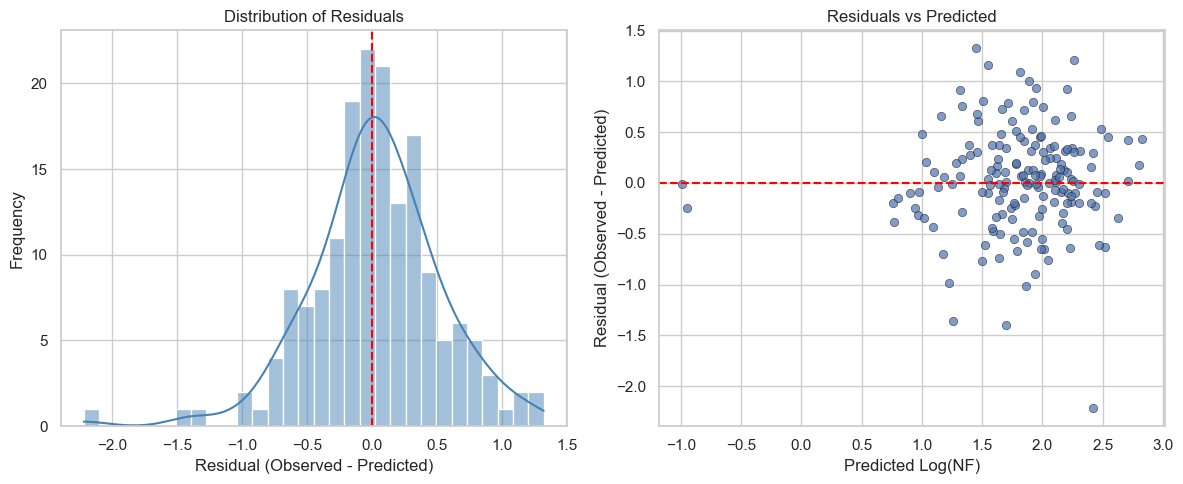

In [112]:
residuals = y_test - y_pred

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# residual + KDE
sns.histplot(residuals, kde=True, bins=30, ax=axs[0], color='steelblue')
axs[0].axvline(0, color='red', linestyle='--')
axs[0].set_title("Distribution of Residuals")
axs[0].set_xlabel("Residual (Observed - Predicted)")
axs[0].set_ylabel("Frequency")

# residual vs predicted
sns.scatterplot(x=y_pred, y=residuals, ax=axs[1], alpha=0.7, edgecolor='k')
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_title("Residuals vs Predicted")
axs[1].set_xlabel("Predicted Log(NF)")
axs[1].set_ylabel("Residual (Observed - Predicted)")

plt.tight_layout()
plt.show()


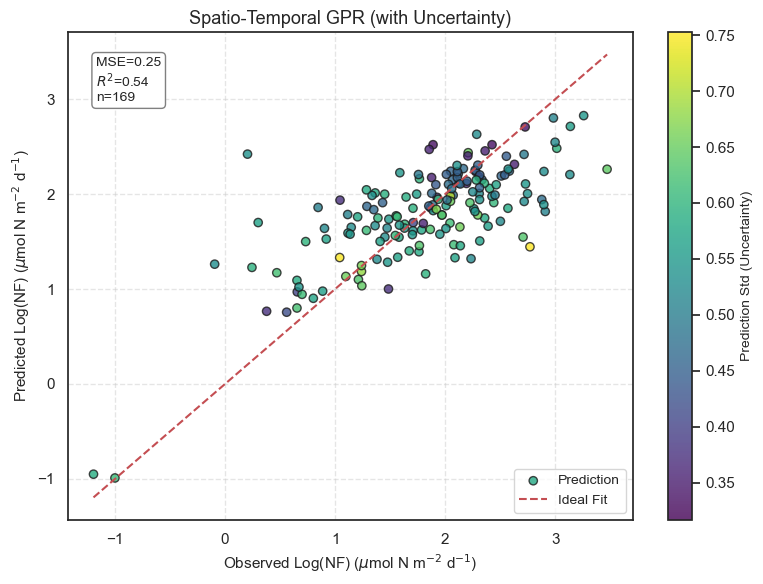

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# sedaborn
sns.set(style='white', context='notebook')

plt.figure(figsize=(8, 6))

# scatter plot
sc = plt.scatter(
    y_test, y_pred,
    c=std_pred, cmap='viridis',
    alpha=0.8, edgecolors='k',
    label='Prediction'
)

# ideal fit
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', label='Ideal Fit'
)

# MSE + R²
plt.text(
    0.05, 0.95, f'MSE={mse:.2f}\n$R^2$={r2:.2f}\nn=169',
    fontsize=10,
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
)

plt.title("Spatio-Temporal GPR (with Uncertainty)", fontsize=13)
plt.xlabel("Observed Log(NF) ($\mu$mol N m$^{-2}$ d$^{-1}$)", fontsize=11)
plt.ylabel("Predicted Log(NF) ($\mu$mol N m$^{-2}$ d$^{-1}$)", fontsize=11)

# colorbar + uncertainty
cbar = plt.colorbar(sc)
cbar.set_label('Prediction Std (Uncertainty)', fontsize=10)

plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("GPR_model.png", dpi=300)
plt.show()


### Global Map

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import joblib 
import os
from scipy.ndimage import generic_filter
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm

PAR_gridded/PAR_01.npz
SST_gridded/SST_01.npz
CHL_gridded/CHL_01.npz
MLD_gridded/MLD_01.npz
Salinity_gridded/Salinity_01.npz
DO_gridded/DO_01.npz
nitrate_gridded/nitrate_01.npz
phosphate_gridded/phosphate_01.npz
Fe_gridded/Fe_01.npz


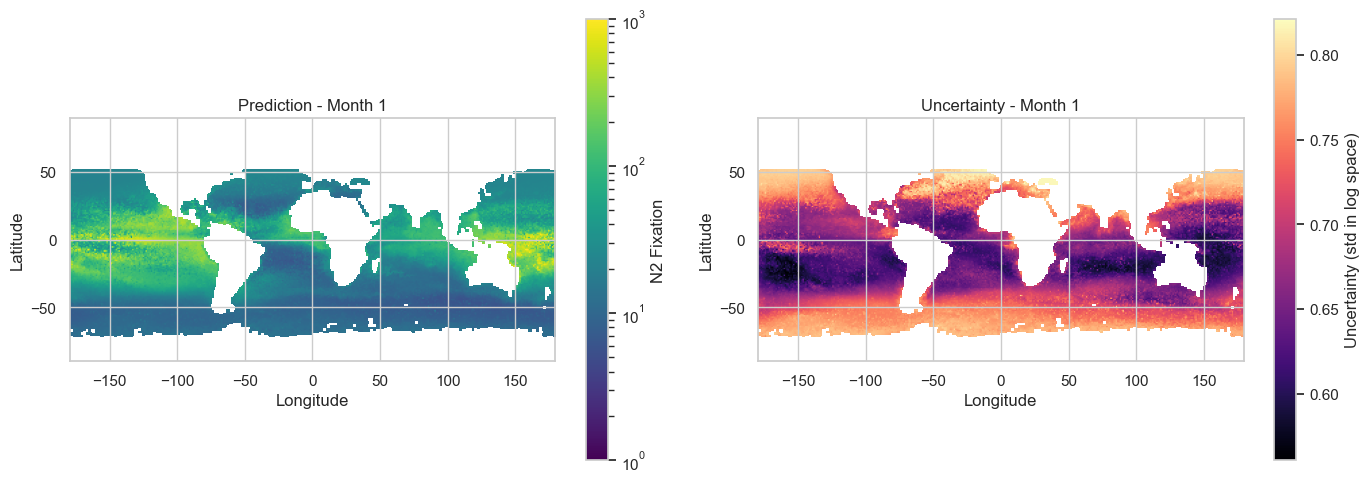

PAR_gridded/PAR_02.npz
SST_gridded/SST_02.npz
CHL_gridded/CHL_02.npz
MLD_gridded/MLD_02.npz
Salinity_gridded/Salinity_02.npz
DO_gridded/DO_02.npz
nitrate_gridded/nitrate_02.npz
phosphate_gridded/phosphate_02.npz
Fe_gridded/Fe_02.npz


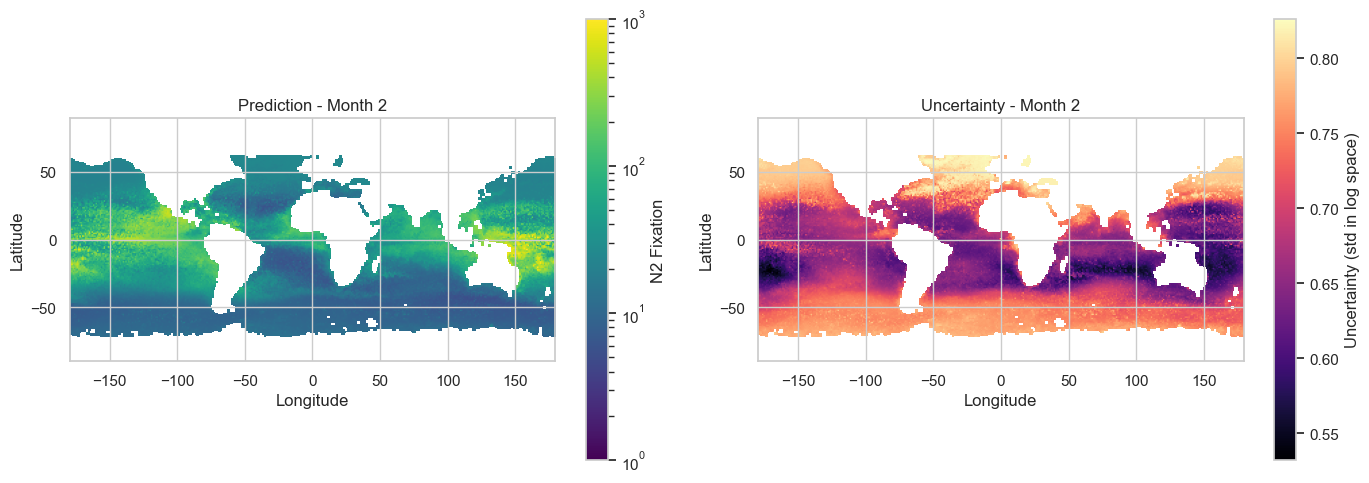

PAR_gridded/PAR_03.npz
SST_gridded/SST_03.npz
CHL_gridded/CHL_03.npz
MLD_gridded/MLD_03.npz
Salinity_gridded/Salinity_03.npz
DO_gridded/DO_03.npz
nitrate_gridded/nitrate_03.npz
phosphate_gridded/phosphate_03.npz
Fe_gridded/Fe_03.npz


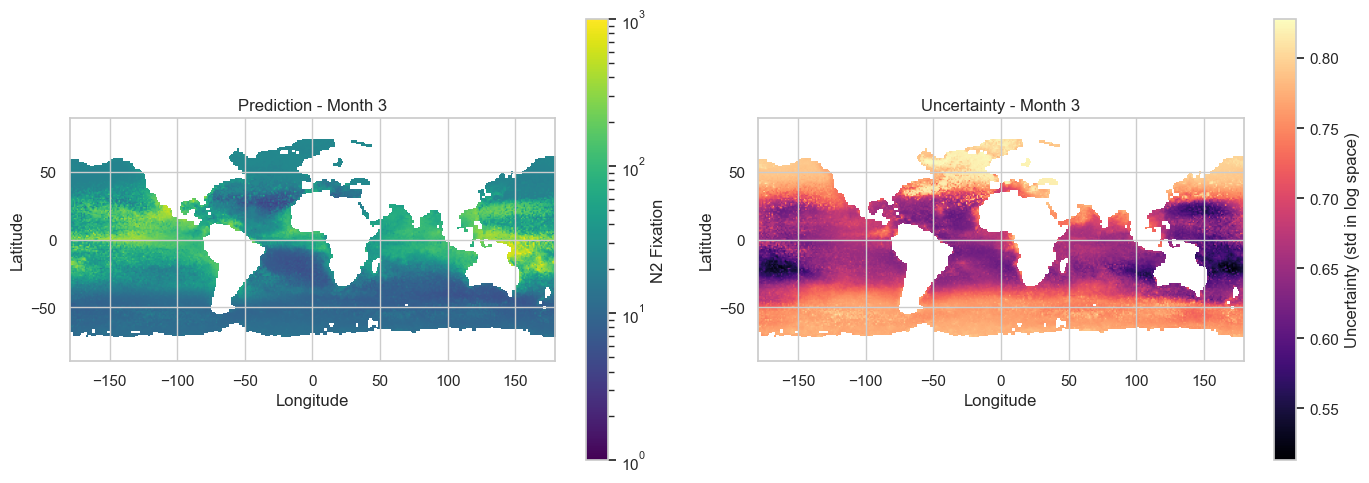

PAR_gridded/PAR_04.npz
SST_gridded/SST_04.npz
CHL_gridded/CHL_04.npz
MLD_gridded/MLD_04.npz
Salinity_gridded/Salinity_04.npz
DO_gridded/DO_04.npz
nitrate_gridded/nitrate_04.npz
phosphate_gridded/phosphate_04.npz
Fe_gridded/Fe_04.npz


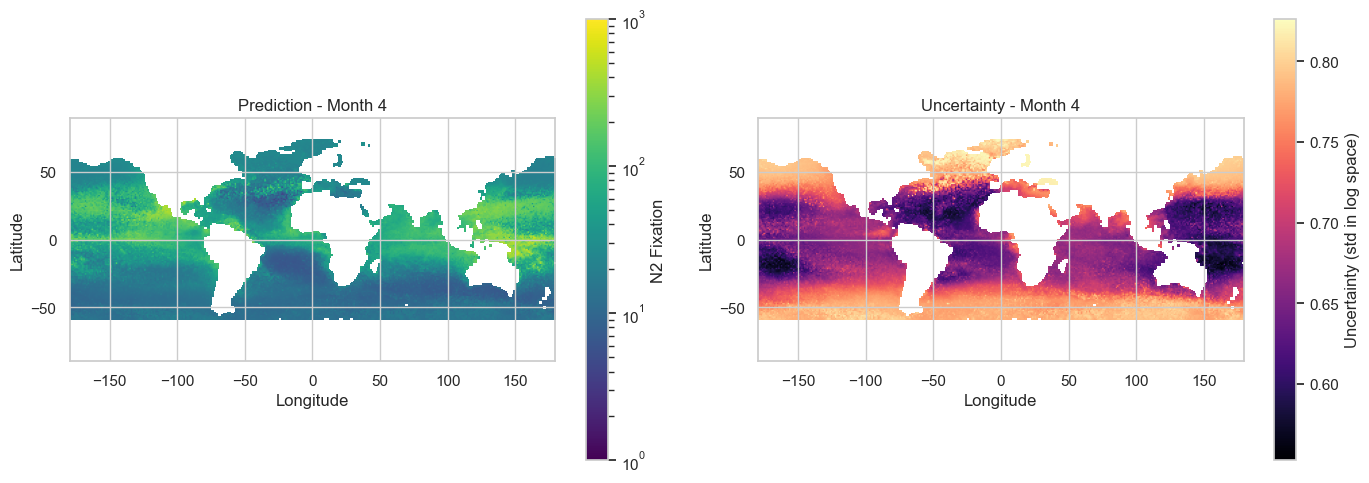

PAR_gridded/PAR_05.npz
SST_gridded/SST_05.npz
CHL_gridded/CHL_05.npz
MLD_gridded/MLD_05.npz
Salinity_gridded/Salinity_05.npz
DO_gridded/DO_05.npz
nitrate_gridded/nitrate_05.npz
phosphate_gridded/phosphate_05.npz
Fe_gridded/Fe_05.npz


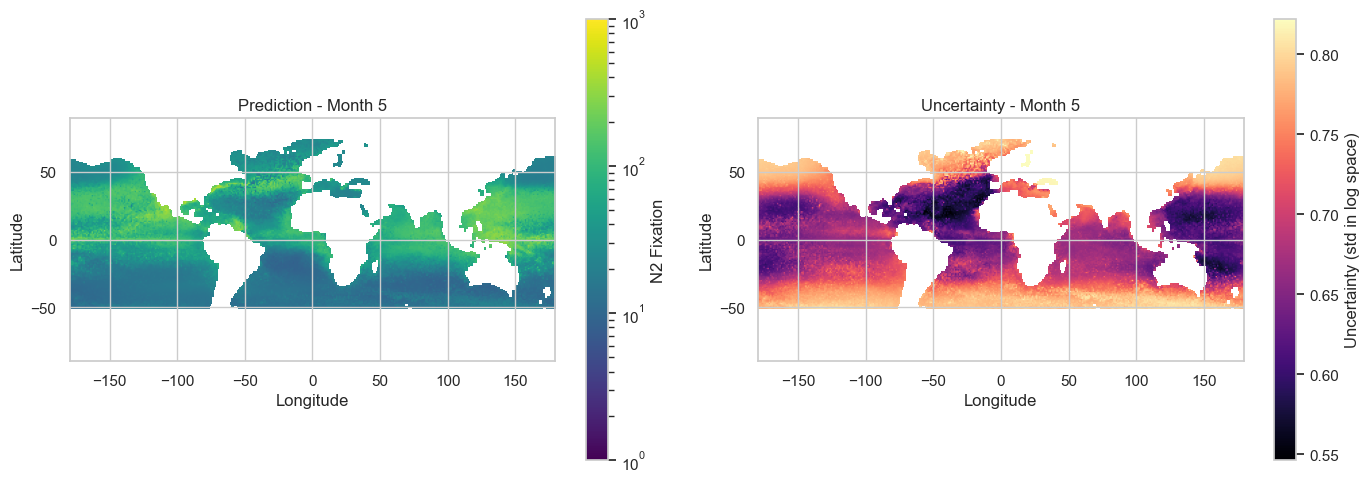

PAR_gridded/PAR_06.npz
SST_gridded/SST_06.npz
CHL_gridded/CHL_06.npz
MLD_gridded/MLD_06.npz
Salinity_gridded/Salinity_06.npz
DO_gridded/DO_06.npz
nitrate_gridded/nitrate_06.npz
phosphate_gridded/phosphate_06.npz
Fe_gridded/Fe_06.npz


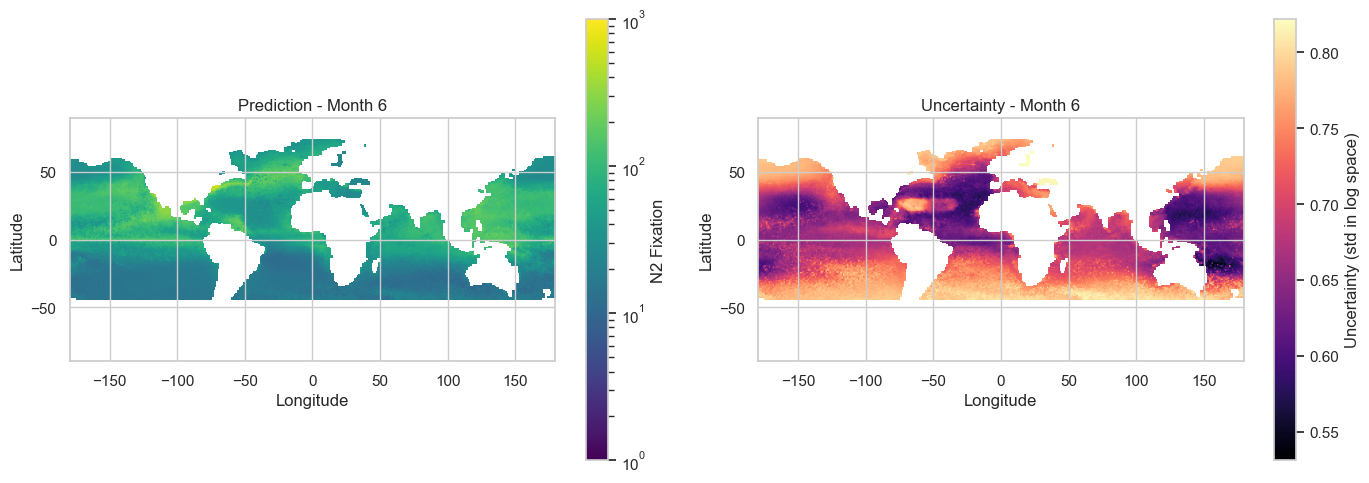

PAR_gridded/PAR_07.npz
SST_gridded/SST_07.npz
CHL_gridded/CHL_07.npz
MLD_gridded/MLD_07.npz
Salinity_gridded/Salinity_07.npz
DO_gridded/DO_07.npz
nitrate_gridded/nitrate_07.npz
phosphate_gridded/phosphate_07.npz
Fe_gridded/Fe_07.npz


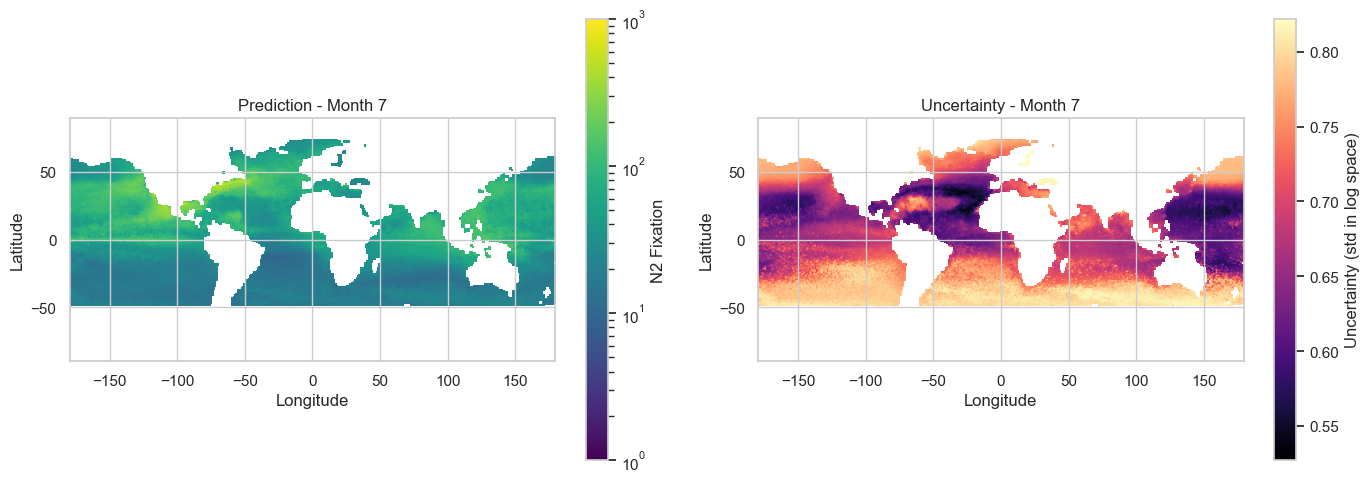

PAR_gridded/PAR_08.npz
SST_gridded/SST_08.npz
CHL_gridded/CHL_08.npz
MLD_gridded/MLD_08.npz
Salinity_gridded/Salinity_08.npz
DO_gridded/DO_08.npz
nitrate_gridded/nitrate_08.npz
phosphate_gridded/phosphate_08.npz
Fe_gridded/Fe_08.npz


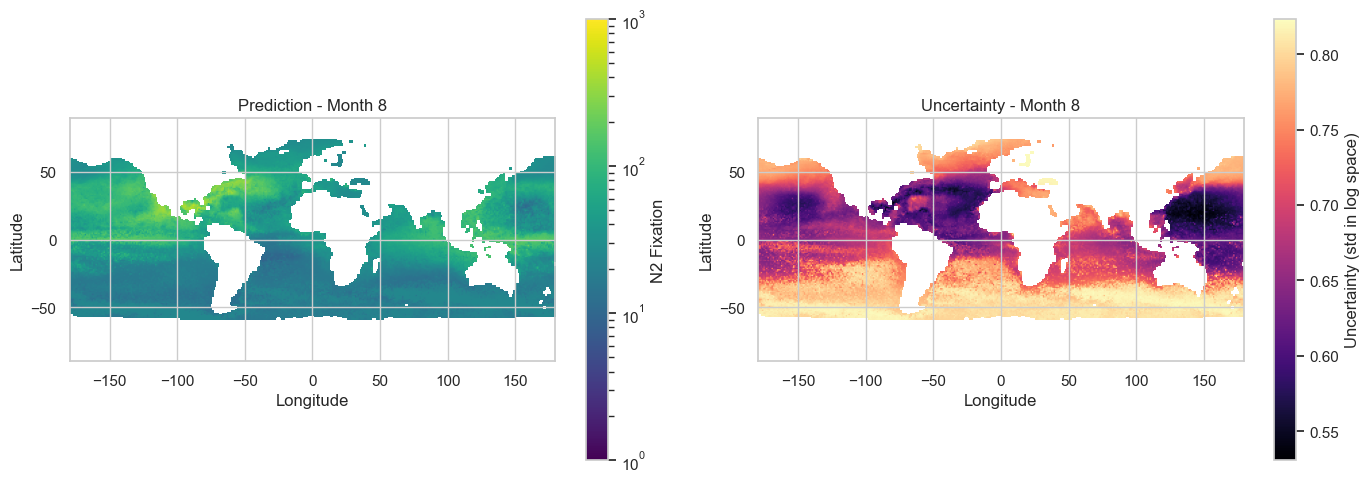

PAR_gridded/PAR_09.npz
SST_gridded/SST_09.npz
CHL_gridded/CHL_09.npz
MLD_gridded/MLD_09.npz
Salinity_gridded/Salinity_09.npz
DO_gridded/DO_09.npz
nitrate_gridded/nitrate_09.npz
phosphate_gridded/phosphate_09.npz
Fe_gridded/Fe_09.npz


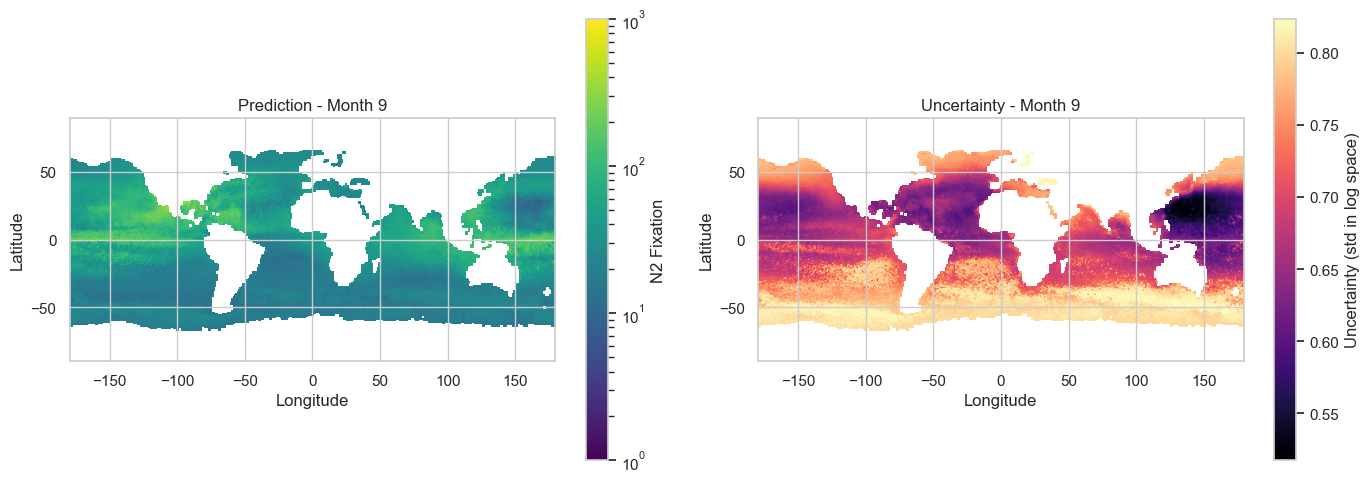

PAR_gridded/PAR_10.npz
SST_gridded/SST_10.npz
CHL_gridded/CHL_10.npz
MLD_gridded/MLD_10.npz
Salinity_gridded/Salinity_10.npz
DO_gridded/DO_10.npz
nitrate_gridded/nitrate_10.npz
phosphate_gridded/phosphate_10.npz
Fe_gridded/Fe_10.npz


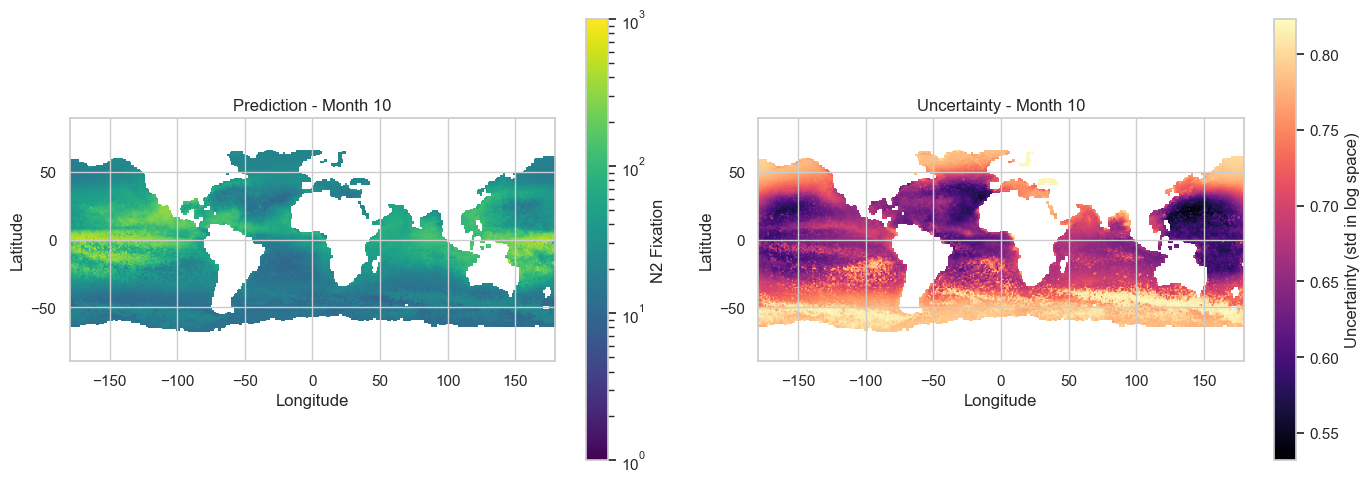

PAR_gridded/PAR_11.npz
SST_gridded/SST_11.npz
CHL_gridded/CHL_11.npz
MLD_gridded/MLD_11.npz
Salinity_gridded/Salinity_11.npz
DO_gridded/DO_11.npz
nitrate_gridded/nitrate_11.npz
phosphate_gridded/phosphate_11.npz
Fe_gridded/Fe_11.npz


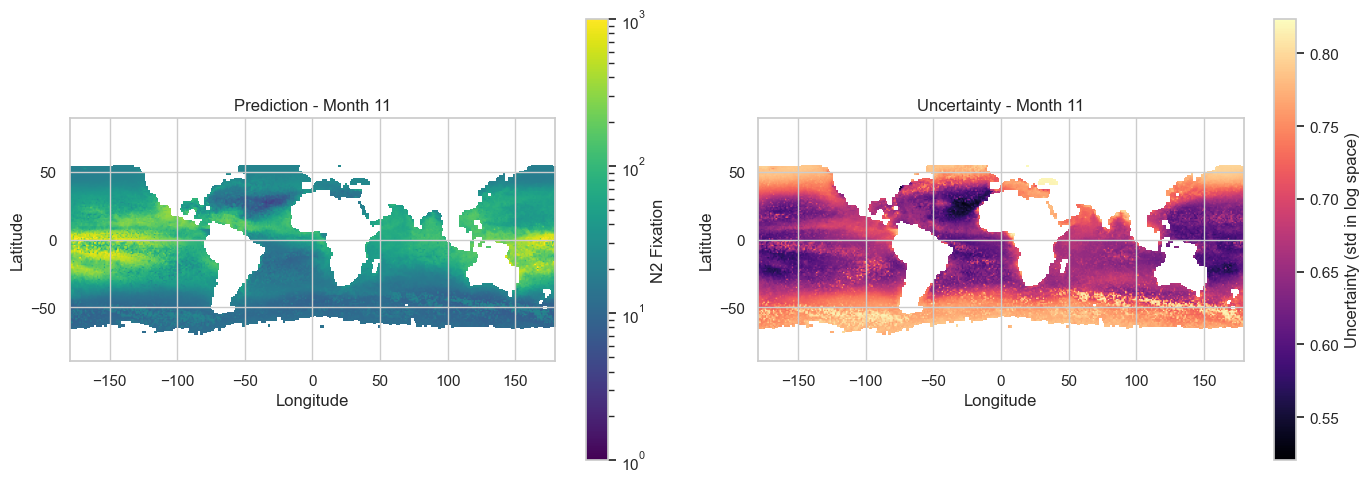

PAR_gridded/PAR_12.npz
SST_gridded/SST_12.npz
CHL_gridded/CHL_12.npz
MLD_gridded/MLD_12.npz
Salinity_gridded/Salinity_12.npz
DO_gridded/DO_12.npz
nitrate_gridded/nitrate_12.npz
phosphate_gridded/phosphate_12.npz
Fe_gridded/Fe_12.npz


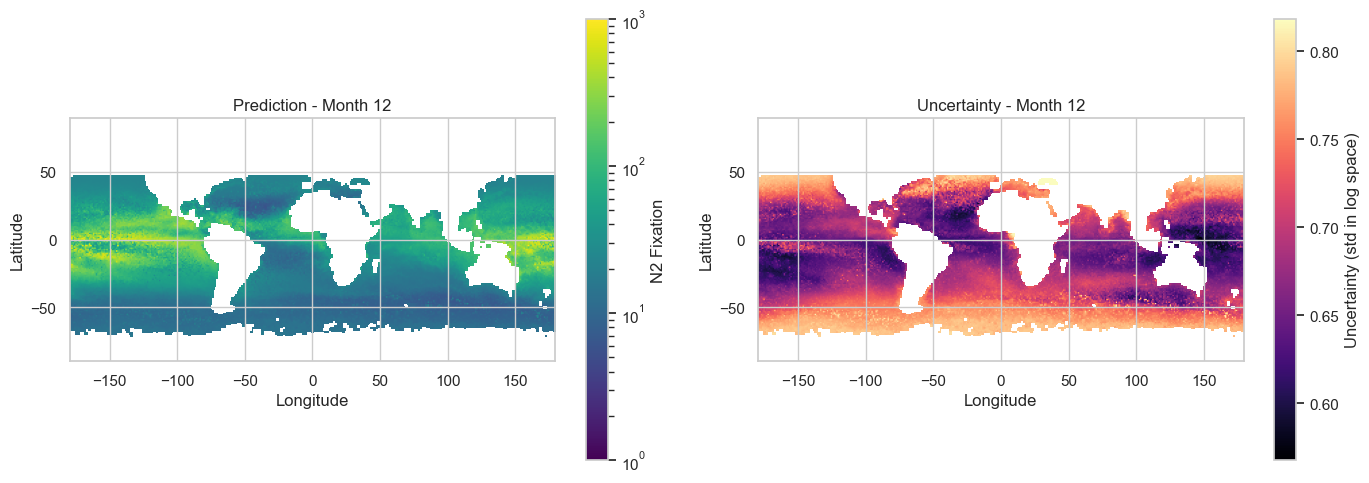

Done!


In [130]:
var_names = ['PAR', 'SST', 'CHL', 'MLD', 'Salinity', 'DO', 'nitrate', 'phosphate', 'Fe']
input_folder = './'  # 每个变量一个文件夹：CHL_gridded, PAR_gridded 等

target_lat = np.linspace(-89.5, 89.5, 180)
target_lon = np.linspace(-179.5, 179.5, 360)
lon_mesh, lat_mesh = np.meshgrid(target_lon, target_lat)

# === 12 months ===
monthly_predictions = []
monthly_uncertainties = []

def nanmean_filter(values):
    """3x3滑动窗口均值（忽略NaN）"""
    valid = values[~np.isnan(values)]
    return np.mean(valid) if valid.size > 0 else np.nan

for month in range(1, 13):
    feature_stack = []

    for var in var_names:
        filepath = os.path.join(f"{var}_gridded", f"{var}_{month:02d}.npz")
        print(filepath)
        data = np.load(filepath)[var if var != 'CHL' else 'CHL']
        #print(data.shape)
        if data.shape != (180, 360):
            data = data.T
        if var == 'CHL':
            data = np.log10(data)  # log10变换
        feature_stack.append(data)

    # 转为 (N, 13) 的输入矩阵
    # 每个feature是 (180, 360)，展开成 (64800,)
    features = [f.ravel() for f in feature_stack]

    # 加入坐标特征
    coord1 = np.sin(np.radians(lat_mesh)).ravel()
    coord2 = (np.sin(np.radians(lon_mesh)) * np.cos(np.radians(lat_mesh))).ravel()
    coord3 = (-np.cos(np.radians(lon_mesh)) * np.cos(np.radians(lat_mesh))).ravel()
    time_cos = np.cos(2 * np.pi * month / 12) * np.ones((180, 360)).ravel()
    time_sin = np.sin(2 * np.pi * month / 12) * np.ones((180, 360)).ravel()

    # 拼接所有特征
    X = np.vstack([coord1, coord2, coord3, time_sin, time_cos] + features).T  # shape (64800, 14)

    valid_mask = ~np.isnan(X).any(axis=1)  # shape=(64800,)
    # not NaN 
    X_valid = X[valid_mask]

    y_pred_log, y_std = best_model.predict(X_valid, return_std=True)

    full_pred_flat = np.full(180 * 360, np.nan)
    full_std_flat = np.full(180 * 360, np.nan)

    full_pred_flat[valid_mask] = np.power(10, y_pred_log)
    full_std_flat[valid_mask] = y_std  # 注意：std在log空间

    pred_map = full_pred_flat.reshape(180, 360)
    std_map = full_std_flat.reshape(180, 360)

    # === sliding window ===
    nan_mask = np.isnan(pred_map)
    smoothed = generic_filter(pred_map, nanmean_filter, size=3, mode='constant', cval=np.nan)
    pred_map[nan_mask] = smoothed[nan_mask]

    nan_mask2 = np.isnan(std_map)
    smoothed2 = generic_filter(std_map, nanmean_filter, size=3, mode='constant', cval=np.nan)
    std_map[nan_mask2] = smoothed2[nan_mask2]

    monthly_predictions.append(pred_map)
    monthly_uncertainties.append(std_map)

    # === save as npz ===
    np.savez_compressed(f'n2fix_{month:02d}.npz', pred=pred_map, std=std_map)

    # === vis+uncertainty ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    im1 = ax1.imshow(pred_map, origin='lower', cmap='viridis', extent=[-179.5, 179.5, -89.5, 89.5], norm=LogNorm(vmin=1, vmax=1000))
    fig.colorbar(im1, ax=ax1, label='N2 Fixation')
    ax1.set_title(f'Prediction - Month {month}')
    ax1.set_xlabel('Longitude'); ax1.set_ylabel('Latitude')

    im2 = ax2.imshow(std_map, origin='lower', cmap='magma', extent=[-179.5, 179.5, -89.5, 89.5])
    fig.colorbar(im2, ax=ax2, label='Uncertainty (std in log space)')
    ax2.set_title(f'Uncertainty - Month {month}')
    ax2.set_xlabel('Longitude'); ax2.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

# === whole year ===
monthly_predictions = np.array(monthly_predictions)  # shape (12, 180, 360)
monthly_uncertainties = np.array(monthly_uncertainties)


print('Done!')

In [131]:
# === 1. 年均固氮量 ===
annual_mean = np.nanmean(monthly_predictions, axis=0)  # (180, 360)

# === 2. 年均uncertainty ===
# 注意不应该直接平均std，而是：
# variance = std^2；annual variance = mean(variance)；再 sqrt
annual_variance = np.nanmean(monthly_uncertainties**2, axis=0)
annual_std = np.sqrt(annual_variance)

print(annual_mean.shape)  # (180, 360)
print(annual_std.shape)


(180, 360)
(180, 360)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_74804/1605208230.py:2: RuntimeWarning: Mean of empty slice
  annual_mean = np.nanmean(monthly_predictions, axis=0)  # (180, 360)
/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_74804/1605208230.py:7: RuntimeWarning: Mean of empty slice
  annual_variance = np.nanmean(monthly_uncertainties**2, axis=0)


In [133]:
# annual_mean
# fill: 3x3 sliding window
filled_once = annual_mean.copy()
nan_mask1 = np.isnan(filled_once)
smoothed1 = generic_filter(filled_once, nanmean_filter, size=3, mode='constant', cval=np.nan)
filled_once[nan_mask1] = smoothed1[nan_mask1]

# 3x3 sliding window
filled_twice = filled_once.copy()
nan_mask2 = np.isnan(filled_twice)
smoothed2 = generic_filter(filled_twice, nanmean_filter, size=3, mode='constant', cval=np.nan)
filled_twice[nan_mask2] = smoothed2[nan_mask2]
annual_mean_filled = filled_twice

# annual_std
# fill: 3x3 sliding window
filled_once = annual_std.copy()
nan_mask1 = np.isnan(filled_once)
smoothed1 = generic_filter(filled_once, nanmean_filter, size=3, mode='constant', cval=np.nan)
filled_once[nan_mask1] = smoothed1[nan_mask1]

# 3x3 sliding window
filled_twice = filled_once.copy()
nan_mask2 = np.isnan(filled_twice)
smoothed2 = generic_filter(filled_twice, nanmean_filter, size=3, mode='constant', cval=np.nan)
filled_twice[nan_mask2] = smoothed2[nan_mask2]
annual_std_filled = filled_twice

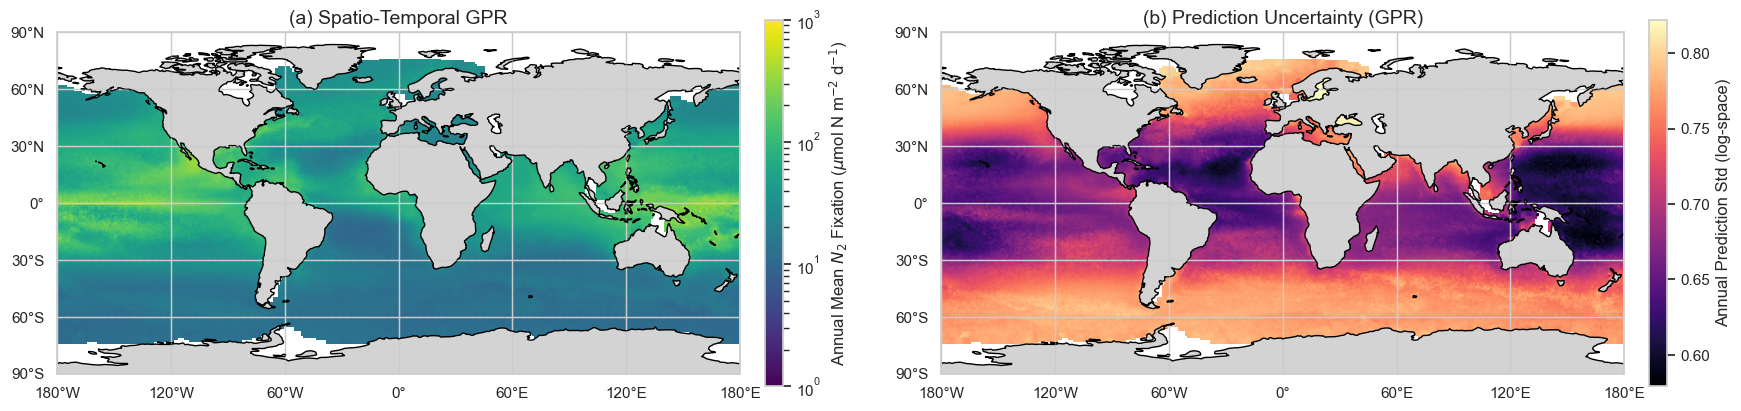

In [136]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors

proj = ccrs.PlateCarree()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': proj})

# === N2 fixation ===
img1 = ax1.imshow(
    annual_mean_filled,
    origin='lower',
    cmap='viridis',
    extent=[-179.5, 179.5, -89.5, 89.5],
    transform=proj,
    norm=colors.LogNorm(vmin=1, vmax=1000)
)

# land + boundary
ax1.coastlines(resolution='110m', linewidth=1)
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)

ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=proj)
ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)
ax1.set_xticklabels(['180°W','120°W','60°W','0°','60°E','120°E','180°E'])
ax1.set_yticklabels(['90°S','60°S','30°S','0°','30°N','60°N','90°N'])
ax1.gridlines(draw_labels=False, linestyle='--', alpha=0.4)

# colorbar （短一点）
cbar1 = fig.colorbar(img1, ax=ax1, orientation='vertical', shrink=0.65, pad=0.03, ticks=[1, 10, 100, 1000])
cbar1.set_label('Annual Mean $N_2$ Fixation ($\mu$mol N m$^{-2}$ d$^{-1}$)')

ax1.set_title('(a) Spatio-Temporal GPR', fontsize=14)

# === (2) 年均uncertainty ===
img2 = ax2.imshow(
    annual_std_filled,
    origin='lower',
    cmap='magma',
    extent=[-179.5, 179.5, -89.5, 89.5],
    transform=proj
)

ax2.coastlines(resolution='110m', linewidth=1)
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)

ax2.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=proj)
ax2.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)
ax2.set_xticklabels(['180°W','120°W','60°W','0°','60°E','120°E','180°E'])
ax2.set_yticklabels(['90°S','60°S','30°S','0°','30°N','60°N','90°N'])
ax2.gridlines(draw_labels=False, linestyle='--', alpha=0.4)

cbar2 = fig.colorbar(img2, ax=ax2, orientation='vertical', shrink=0.65, pad=0.03)
cbar2.set_label('Annual Prediction Std (log-space)')

ax2.set_title('(b) Prediction Uncertainty (GPR)', fontsize=14)

plt.tight_layout()
plt.savefig("n2fix_gpr.png", dpi=300)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


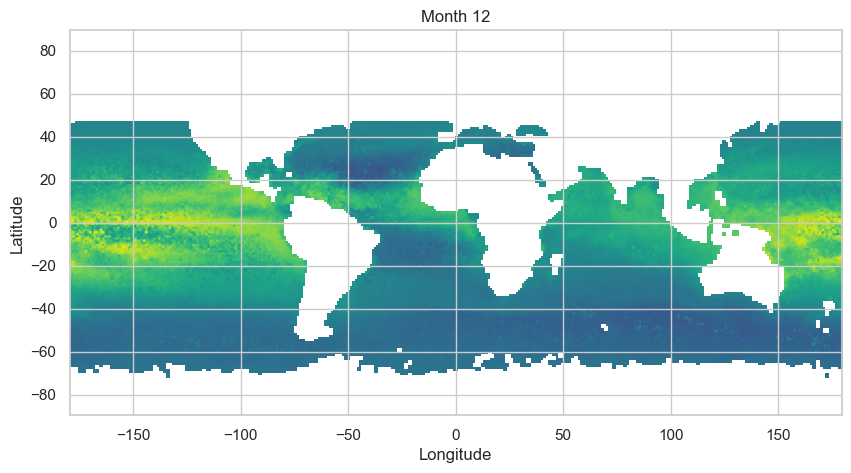

In [138]:
fig, ax = plt.subplots(figsize=(10, 5))

def update(frame):
    ax.clear()
    im = ax.imshow(monthly_predictions[frame], origin='lower', cmap='viridis', extent=[-179.5, 179.5, -89.5, 89.5], norm=LogNorm(vmin=1, vmax=1000))
    ax.set_title(f'Month {frame+1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return im,

ani = FuncAnimation(fig, update, frames=12, interval=500, blit=False)

ani.save('n2fix_seasonal.gif', fps=2)
plt.show()


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_74804/2414529523.py:12: RuntimeWarning: Mean of empty slice
  annual_avg = np.nanmean(np.stack(monthly_predictions), axis=0)


<Figure size 1200x500 with 0 Axes>

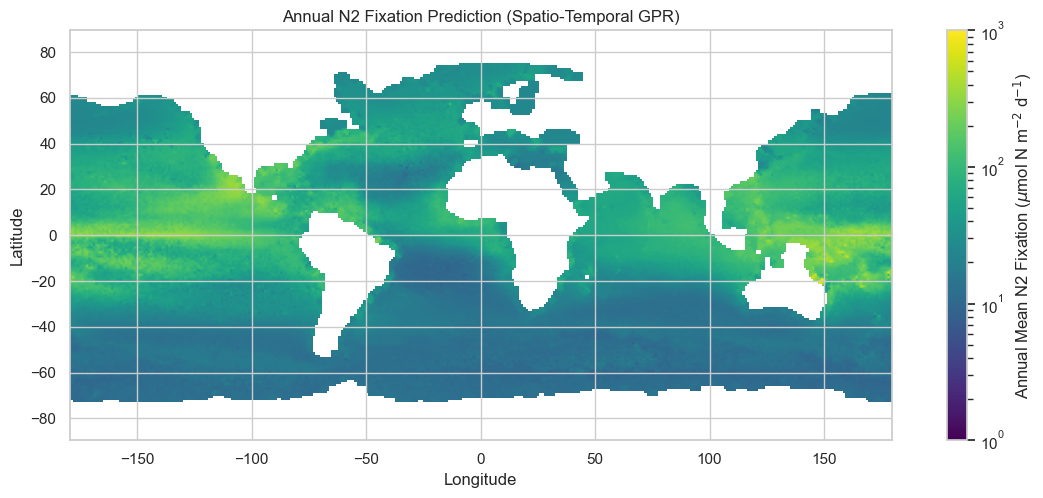

In [122]:
#### ------- Fill with the neighborhood mean (3x3 grid) -------- ####
import numpy as np
from scipy.ndimage import generic_filter
from matplotlib.colors import LogNorm

def nanmean_filter(values):
    """计算非nan值的均值"""
    valid = values[~np.isnan(values)]
    return np.mean(valid) if valid.size > 0 else np.nan

# annual avg
annual_avg = np.nanmean(np.stack(monthly_predictions), axis=0)

# fill: 3x3 sliding window
filled_once = annual_avg.copy()
nan_mask1 = np.isnan(filled_once)
smoothed1 = generic_filter(filled_once, nanmean_filter, size=3, mode='constant', cval=np.nan)
filled_once[nan_mask1] = smoothed1[nan_mask1]

# 3x3 sliding window
filled_twice = filled_once.copy()
nan_mask2 = np.isnan(filled_twice)
smoothed2 = generic_filter(filled_twice, nanmean_filter, size=3, mode='constant', cval=np.nan)
filled_twice[nan_mask2] = smoothed2[nan_mask2]

annual_filled = filled_twice

plt.figure(figsize=(12, 5))
plt.figure(figsize=(12, 5))
plt.imshow(
    annual_filled, 
    origin='lower', 
    cmap='viridis', 
    extent=[-179.5, 179.5, -89.5, 89.5],
    norm=LogNorm(vmin=1, vmax=1000)
)

cbar = plt.colorbar(ticks=[1, 10, 100, 1000])
cbar.set_label('Annual Mean N2 Fixation ($\mu$mol N m$^{-2}$ d$^{-1}$)')

plt.title('Annual N2 Fixation Prediction (Spatio-Temporal GPR)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


In [123]:
# grid
lat = np.linspace(-89.5, 89.5, 180)
lon = np.linspace(-179.5, 179.5, 360)
# save as .npz
np.savez('annual_gpr.npz', lat=lat, lon=lon, n2fix=annual_filled)


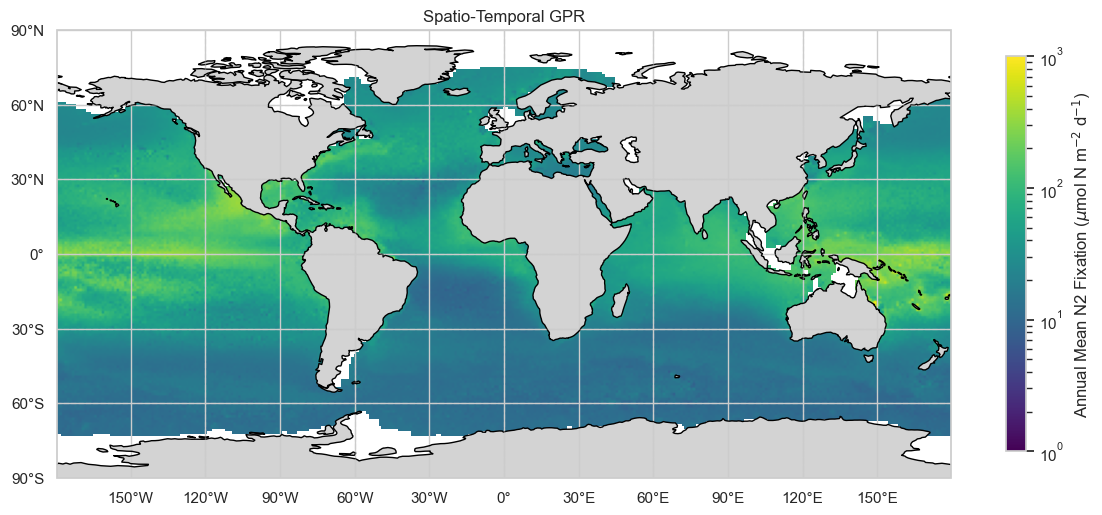

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === load data ===
data = np.load('annual_gpr.npz')
lat = data['lat']
lon = data['lon']
annual_filled = data['n2fix']

# === ploy ===
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=proj)

img = ax.imshow(
    annual_filled,
    origin='lower',
    cmap='viridis',
    extent=[lon.min(), lon.max(), lat.min(), lat.max()],
    transform=proj,
    norm=LogNorm(vmin=1, vmax=1000)
)






# land and boundary
ax.coastlines(resolution='110m', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)

# label
ax.set_xticks([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150], crs=proj)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)

ax.set_xticklabels(['150°W','120°W','90°W','60°W','30°W','0°','30°E','60°E','90°E','120°E','150°E'])
ax.set_yticklabels(['90°S','60°S','30°S','0°','30°N','60°N','90°N'])

ax.gridlines(draw_labels=False, linestyle='--', alpha=0.4)

# colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7, pad=0.05,ticks=[1, 10, 100, 1000])

cbar.set_label('Annual Mean N2 Fixation ($\mu$mol N m$^{-2}$ d$^{-1}$)')

plt.title('Spatio-Temporal GPR')
plt.tight_layout()
plt.savefig("GPR_map.png", dpi=300)
plt.show()


### Hot Spot Places

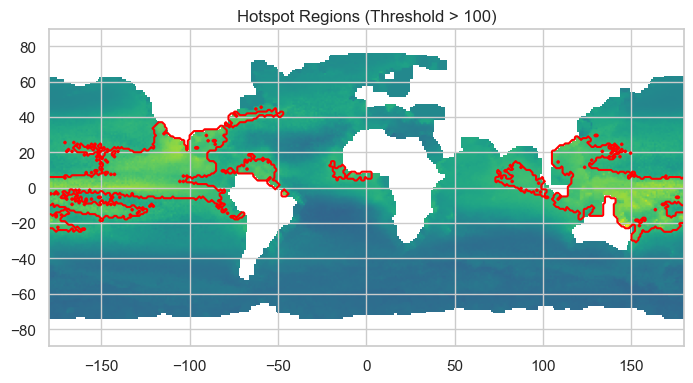

In [170]:

hotspot_mask = annual_mean_filled > 100  # 固氮量阈值（μmol N m⁻² d⁻¹）

# 可视化热点轮廓
plt.figure(figsize=(10, 4))
plt.imshow(annual_mean_filled, origin='lower', extent=[-179.5, 179.5, -89.5, 89.5], cmap='viridis', norm=LogNorm(vmin=1, vmax=1000))
plt.contour(hotspot_mask, levels=[0.5], colors='red', linewidths=1.5, extent=[-179.5, 179.5, -89.5, 89.5])
plt.title('Hotspot Regions (Threshold > 100)')
#plt.colorbar(label='Annual N2 Fixation')
plt.tight_layout()
plt.show()


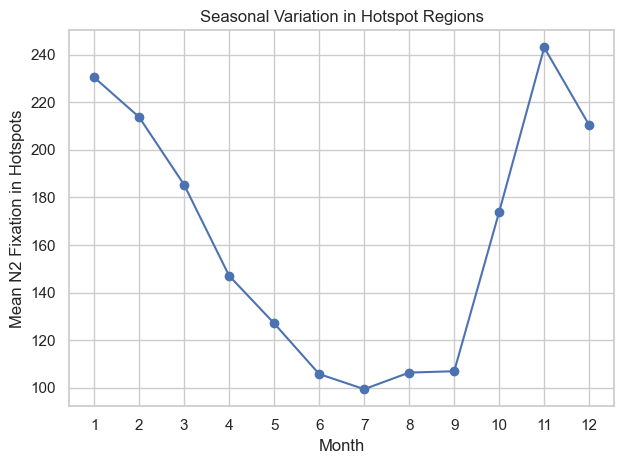

In [171]:
time_series = [np.nanmean(month[hotspot_mask]) for month in monthly_predictions]

plt.figure()
plt.plot(range(1, 13), time_series, marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Mean N2 Fixation in Hotspots')
plt.title('Seasonal Variation in Hotspot Regions')
plt.grid(True)
plt.tight_layout()
plt.show()


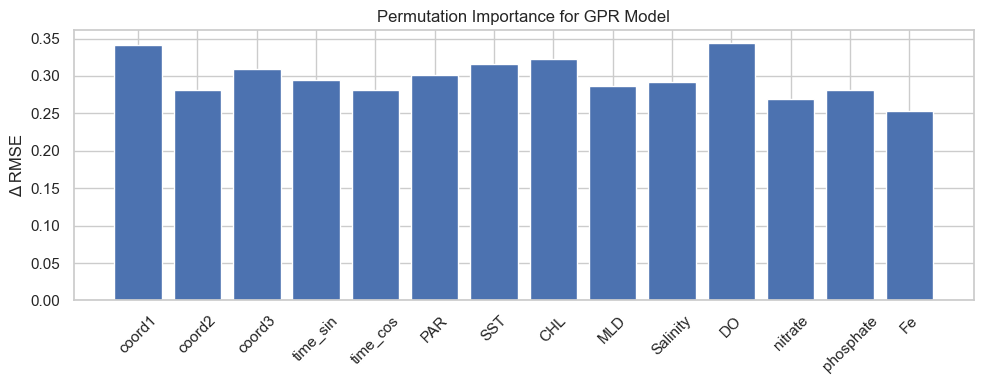

In [166]:
from sklearn.metrics import mean_squared_error
import copy

# X_valid 是 shape=(N, 14)，已经准备好的输入特征（包含 coord, time, env）
base_preds = best_model.predict(X_train)
base_rmse = np.sqrt(mean_squared_error(y_train, base_preds))

feature_names = ['coord1', 'coord2', 'coord3', 'time_sin', 'time_cos'] + var_names
importances = []

for i, name in enumerate(feature_names):
    X_perm = X_train.copy()
    np.random.shuffle(X_perm[:, i])  # 打乱第 i 列
    perm_preds = best_model.predict(X_perm)
    perm_rmse = np.sqrt(mean_squared_error(y_train, perm_preds))
    delta = perm_rmse - base_rmse
    importances.append(delta)

# 可视化
plt.figure(figsize=(10, 4))
plt.bar(feature_names, importances)
plt.ylabel('Δ RMSE')
plt.title('Permutation Importance for GPR Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


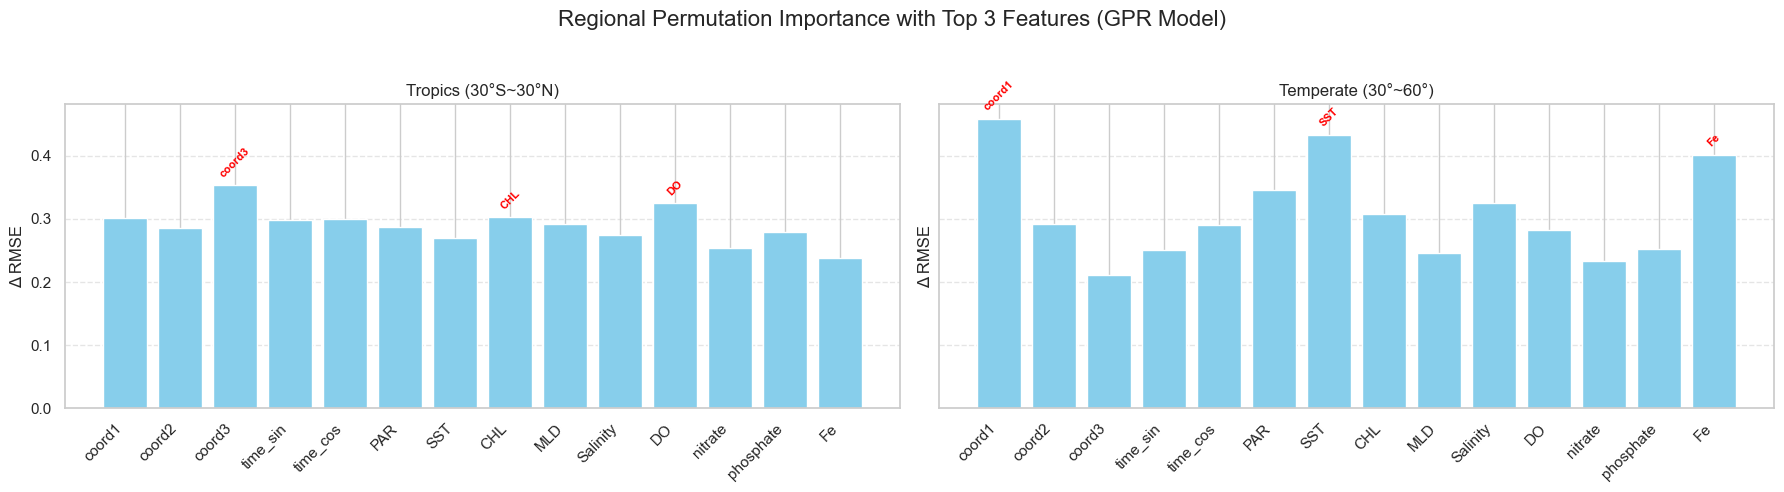

In [167]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 特征名
feature_names = ['coord1', 'coord2', 'coord3', 'time_sin', 'time_cos'] + var_names

# 纬度信息
latitudes = np.degrees(np.arcsin(X_train[:, 0]))  # 因为 coord1 = sin(lat)

# 区域mask
tropical_mask = (latitudes >= -30) & (latitudes <= 30)
temperate_mask = ((latitudes > 30) & (latitudes <= 60)) | ((latitudes >= -60) & (latitudes < -30))
polar_mask = (latitudes > 60) | (latitudes < -60)

region_masks = {
    'Tropics (30°S~30°N)': tropical_mask,
    'Temperate (30°~60°)': temperate_mask
    
}

# 存放每个区域的重要性
region_importances = {}

# 遍历区域
for region_name, mask in region_masks.items():
    X_region = X_train[mask]
    y_region = y_train[mask]

    if len(y_region) == 0:
        continue

    base_preds = best_model.predict(X_region)
    base_rmse = np.sqrt(mean_squared_error(y_region, base_preds))

    importances = []

    for i, name in enumerate(feature_names):
        X_perm = X_region.copy()
        np.random.shuffle(X_perm[:, i])
        perm_preds = best_model.predict(X_perm)
        perm_rmse = np.sqrt(mean_squared_error(y_region, perm_preds))
        delta = perm_rmse - base_rmse
        importances.append(delta)

    region_importances[region_name] = importances

# 🎨 可视化
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

for ax, (region_name, importances) in zip(axes, region_importances.items()):
    importances = np.array(importances)
    colors = ['gray' if val < 0 else 'skyblue' for val in importances]

    bars = ax.bar(feature_names, importances, color=colors)

    # 标出Top 3
    top3_idx = np.argsort(importances)[-3:][::-1]  # 从大到小
    for idx in top3_idx:
        ax.text(idx, importances[idx] + 0.01, feature_names[idx],
                ha='center', va='bottom', color='red', fontsize=8, fontweight='bold', rotation=45)

    ax.set_title(region_name)
    ax.set_ylabel('Δ RMSE')
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Regional Permutation Importance with Top 3 Features (GPR Model)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


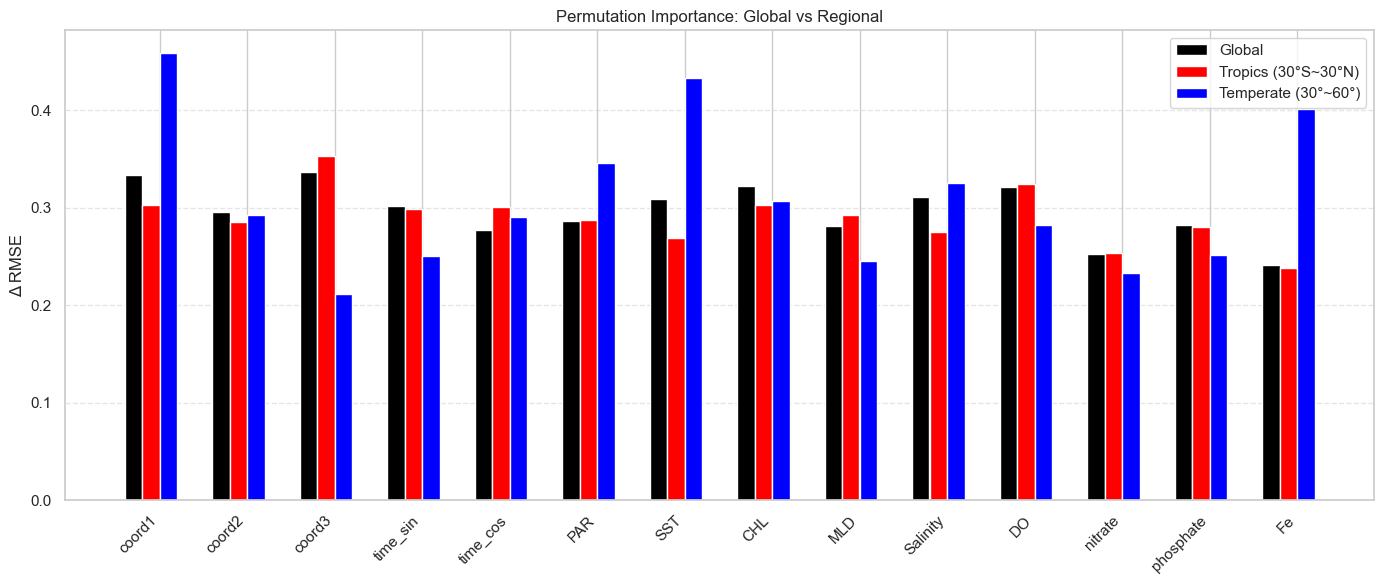

In [169]:
import numpy as np
import matplotlib.pyplot as plt

# 假设：region_importances 已经计算好，包括全局和分区
# 先计算全局
base_preds = best_model.predict(X_train)
base_rmse = np.sqrt(mean_squared_error(y_train, base_preds))

global_importances = []
for i, name in enumerate(feature_names):
    X_perm = X_train.copy()
    np.random.shuffle(X_perm[:, i])
    perm_preds = best_model.predict(X_perm)
    perm_rmse = np.sqrt(mean_squared_error(y_train, perm_preds))
    delta = perm_rmse - base_rmse
    global_importances.append(delta)

# 整理所有区域
all_regions = {
    'Global': global_importances,
    **region_importances  # 已经有 Tropics/Temperate/Polar
}

# 画图
bar_width = 0.2
x = np.arange(len(feature_names))

fig, ax = plt.subplots(figsize=(14, 6))

colors = {
    'Global': 'black',
    'Tropics (30°S~30°N)': 'red',
    'Temperate (30°~60°)': 'blue'
}

for i, (region_name, importances) in enumerate(all_regions.items()):
    importances = np.array(importances)
    display_colors = ['gray' if val < 0 else colors.get(region_name, 'skyblue') for val in importances]
    ax.bar(x + i * bar_width, importances, width=bar_width, color=display_colors, label=region_name)

ax.set_xticks(x + 1.5 * bar_width)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_ylabel('Δ RMSE')
ax.set_title('Permutation Importance: Global vs Regional')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Permutation_Importance.png")
plt.show()
